# 投資信託の評価

In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import yfinance as yf

from dividends_reinvestment_return import dividends_reinvestment_return

In [36]:
# データの読み込み
path = '../../../../data/raw/investment_trust.parquet'
df = pl.read_parquet(path)
df.head()

isin_code,investment_trust_association_japan_code,investment_name,date,nav,net_assets_million
str,str,str,date,i64,f64
null,"""0431U169""","""ifree_emerging_markets_bond_in…",2016-09-08,10053,1.005303
null,"""0431U169""","""ifree_emerging_markets_bond_in…",2016-09-09,10089,1.008859
null,"""0431U169""","""ifree_emerging_markets_bond_in…",2016-09-12,9994,1.936575
null,"""0431U169""","""ifree_emerging_markets_bond_in…",2016-09-13,9893,2.309483
null,"""0431U169""","""ifree_emerging_markets_bond_in…",2016-09-14,9912,2.98453


In [37]:
# 銘柄名，コードの確認
df[['investment_trust_association_japan_code', 'investment_name']].unique()

investment_trust_association_japan_code,investment_name
str,str
"""0331418A""","""emaxis_slim_all_world_equity_a…"
"""0331C177""","""emaxis_slim_emerging_markets_e…"
"""3312175""","""emaxis_slim_balance_8_asset_eq…"
"""0431U169""","""ifree_emerging_markets_bond_in…"
"""89311216""","""sbi_v_us_equity_index_fund"""
"""3312184""","""emaxis_slim_all_country_3_regi…"
"""3311187""","""emaxis_slim_us_equity_sp500"""
"""0331A172""","""emaxis_slim_developed_governme…"
"""8931117C""","""sbi_emerging_markets_equity_in…"


## オルカン

In [16]:
all_country = df.filter(pl.col('investment_trust_association_japan_code') == '0331418A')

# 月末のデータのみを抽出
end_of_month = all_country.select(
    pl.col('date').dt.month_end().unique()
)
all_country_monthly = all_country.filter(
    pl.col('date').is_in(end_of_month)
)

# 対数
all_country_monthly = all_country_monthly.with_columns(
    pl.col('nav').log().alias('log_nav')
)
all_country_monthly = all_country_monthly.with_columns(
    pl.col('log_nav').diff().alias('log_nav_diff')
)

all_country_monthly.head()

isin_code,investment_trust_association_japan_code,investment_name,date,nav,net_assets_million,log_nav,log_nav_diff
str,str,str,date,i64,f64,f64,f64
"""JP90C000H1T1""","""0331418A""","""emaxis_slim_all_world_equity_a…",2018-10-31,10000,10.0,9.21034,null
"""JP90C000H1T1""","""0331418A""","""emaxis_slim_all_world_equity_a…",2018-11-30,10271,367.0,9.23708,0.026739
"""JP90C000H1T1""","""0331418A""","""emaxis_slim_all_world_equity_a…",2019-01-31,9848,1206.0,9.195024,-0.042056
"""JP90C000H1T1""","""0331418A""","""emaxis_slim_all_world_equity_a…",2019-02-28,10387,1852.0,9.24831,0.053287
"""JP90C000H1T1""","""0331418A""","""emaxis_slim_all_world_equity_a…",2019-05-31,10142,3616.0,9.22444,-0.02387


Text(0.5, 1.0, 'オルカン')

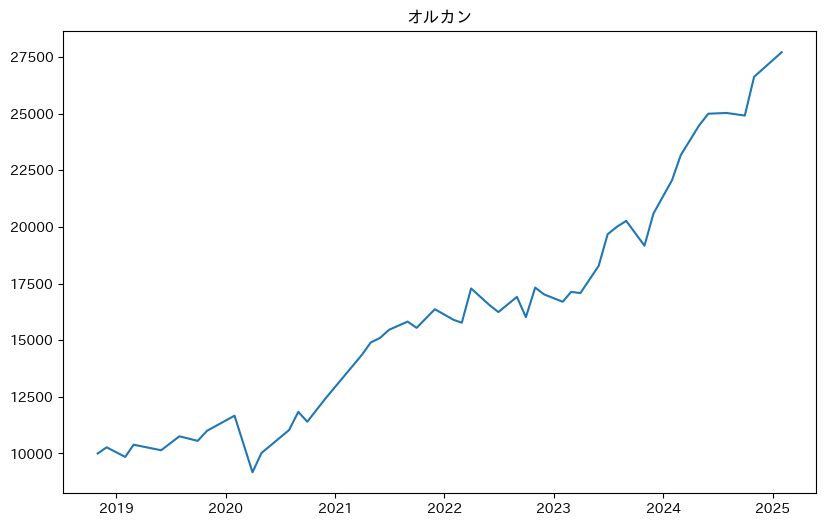

In [47]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(all_country_monthly['date'], all_country_monthly['nav'])
ax.set_title('オルカン')

In [45]:
# return
n_years = len(all_country_monthly) / 12
v_first = all_country_monthly['nav'][0]
v_last = all_country_monthly['nav'][-1]
cagr = (v_last / v_first) ** (1 / n_years) - 1
print(f'年率リターン: {cagr:.2%}')

# volatility
vol = np.std(all_country_monthly['log_nav_diff'].drop_nulls().to_numpy()) * np.sqrt(12)
print(f'ボラティリティ: {vol:.2%}')

# sharpe ratio
rf = 0.0
sharpe_ratio = (cagr - rf) / vol
print(f'Sharpe ratio: {sharpe_ratio:.2f}')

年率リターン: 28.35%
ボラティリティ: 20.20%
Sharpe ratio: 1.40


## eMAXIS Slim 先進国債 インデックス

return: 6.48%
volatility: 11.54%
sharp ratio: 0.56


Text(0, 0.5, '累積リターン (%)')

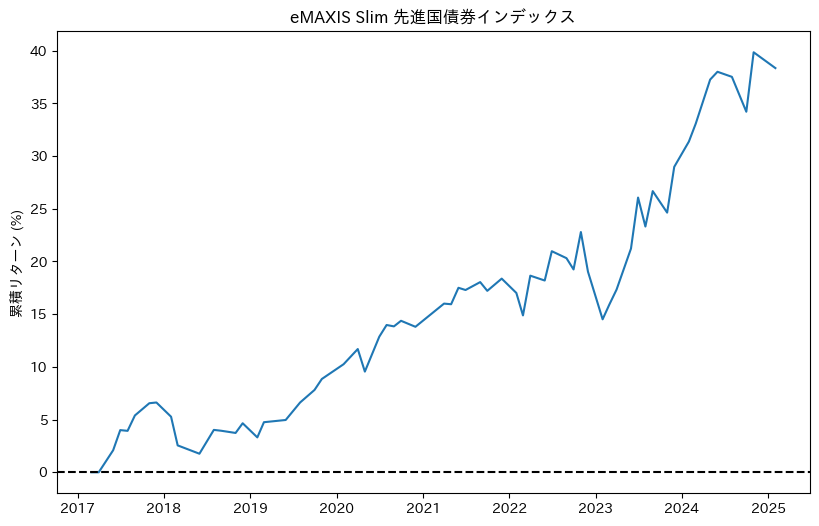

In [230]:
dev_bond = df.filter(pl.col('investment_trust_association_japan_code') == '0331A172')
dev_bond.head()

end_of_month = dev_bond.select(
    pl.col('date').dt.month_end().unique()
)
dev_bond = dev_bond.filter(
    pl.col('date').is_in(end_of_month)
)
dev_bond = dev_bond.with_columns(
    pl.col('nav').log().alias('nav_log'),
    pl.col('nav').log().diff().alias('nav_log_diff')
)
dev_bond = dev_bond.with_columns(
    (pl.col('nav_log') - dev_bond['nav_log'][0]).alias('log_return'),
)
dev_bond = dev_bond.with_columns(
    ((pl.col('log_return').exp() - 1) * 100).alias('return')
)

years = len(dev_bond) / 12
v_first = dev_bond['nav'][0]
v_last = dev_bond['nav'][-1]
dev_bond_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'return: {dev_bond_cagr:.2%}')

dev_vol = np.std(dev_bond['nav_log_diff'].drop_nulls().to_numpy()) * np.sqrt(12)
print(f'volatility: {vol:.2%}')

rf = 0
sharpe_ratio = (dev_bond_cagr - rf) / vol
print(f'sharp ratio: {sharpe_ratio:.2f}')

fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(dev_bond['date'], dev_bond['return'])
ax.axhline(0, ls='--', color='black')
ax.set_title('eMAXIS Slim 先進国債券インデックス')
ax.set_ylabel('累積リターン (%)')

## 上場豪債

In [229]:
ticker = yf.Ticker('2844.T')
historical_data = ticker.history(period='max', interval='1mo')
au_bond = pl.DataFrame({
    'date': historical_data.index,
    'Close': historical_data['Close'],
    'Dividends': historical_data['Dividends'],
}).with_columns(
    pl.col('date').cast(pl.Date),
)

au_bond = dividends_reinvestment_return(au_bond, initial_shares=10000)

au_bond.head()

years = len(au_bond) / 12
v_first = au_bond['Value'][0]
v_last = au_bond['Value'][-1]
au_bond_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'年率リターン: {au_bond_cagr:.2%}')

log_diff = au_bond['Close'].log().diff()
au_vol = np.std(log_diff.drop_nulls().to_numpy()) * np.sqrt(12)
print(f'ボラティリティ: {vol:.2%}')

rf = 0.0
sharpe_ratio = (au_bond_cagr - rf) / vol
print(f'Sharpe ratio: {sharpe_ratio:.2f}')

年率リターン: 7.01%
ボラティリティ: 11.54%
Sharpe ratio: 0.61


Text(0.5, 1.0, '上場豪債')

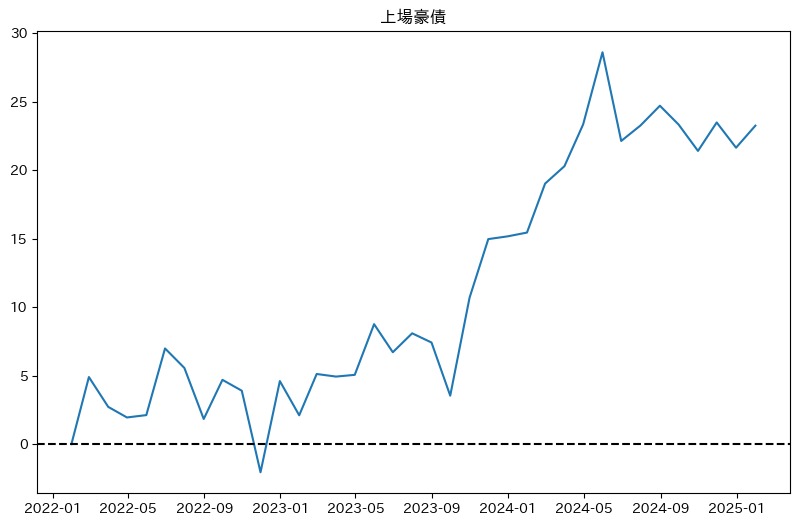

In [107]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(au_bond['date'], au_bond['Return'])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_title('上場豪債')

## ABFシンガポール債券

In [231]:
ticker = yf.Tickers(['A35.SI', 'SGDJPY=X'])
historical_data = ticker.history(period='max', interval='1d')

sg_bond = pl.DataFrame({
    'date': historical_data.index,
    'Close': historical_data['Close']['A35.SI'] * historical_data['Close']['SGDJPY=X'],
    'Dividends': historical_data['Dividends']['A35.SI'] * historical_data['Close']['SGDJPY=X'],
}).drop_nulls().with_columns(
    pl.col('date').cast(pl.Date),
)
end_of_month = sg_bond.select(
    pl.col('date').dt.month_end().unique()
)
sg_bond = sg_bond.filter(
    pl.col('date').is_in(end_of_month)
)
sg_bond = dividends_reinvestment_return(sg_bond, initial_shares=10000)
sg_bond.head()

years = len(sg_bond) / 12
v_first = sg_bond['Value'][0]
v_last = sg_bond['Value'][-1]
sg_bond_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'return: {sg_bond_cagr:.2%}')

log_diff = sg_bond['Close'].log().diff().drop_nulls().to_numpy()
sg_vol = np.std(log_diff) * np.sqrt(12)
print(f'volatility: {vol:.2%}')

rf = 0
sharpe_ratio = (sg_bond_cagr - rf) / vol
print(f'sharp ratio: {sharpe_ratio:.2f}')

[*********************100%***********************]  2 of 2 completed

return: 6.02%
volatility: 11.54%
sharp ratio: 0.52


Text(0.5, 1.0, 'ABFシンガポール債')

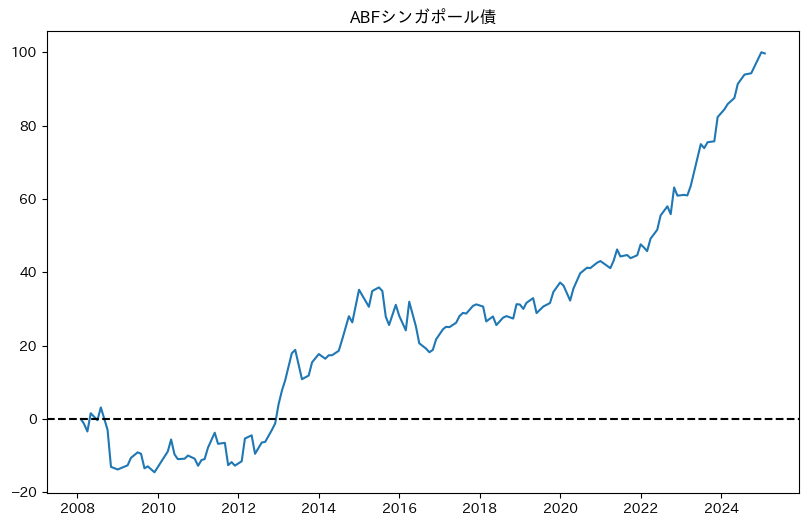

In [232]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(sg_bond['date'], sg_bond['Return'])
ax.axhline(y=0, color='black', linestyle='--')
ax.set_title('ABFシンガポール債')

## iFree 新興国債券インデックス

return: 8.67%
volatility: 11.54%
sharp ratio: 0.75


Text(0, 0.5, '累積リターン (%)')

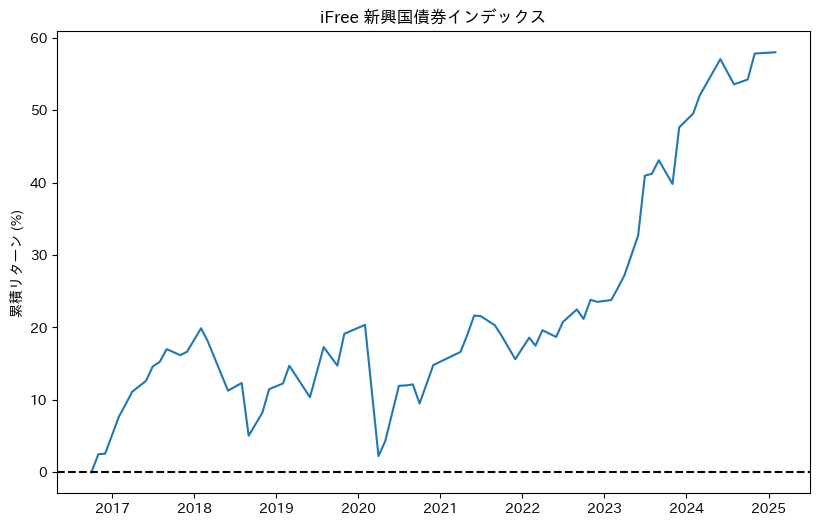

In [233]:
em_bond = df.filter(pl.col('investment_trust_association_japan_code') == '0431U169')
em_bond.head()

end_of_month = em_bond.select(
    pl.col('date').dt.month_end().unique()
)
em_bond = em_bond.filter(
    pl.col('date').is_in(end_of_month)
)
em_bond = em_bond.with_columns(
    pl.col('nav').log().alias('nav_log'),
    pl.col('nav').log().diff().alias('nav_log_diff')
)
em_bond = em_bond.with_columns(
    (pl.col('nav_log') - em_bond['nav_log'][0]).alias('log_return'),
)
em_bond = em_bond.with_columns(
    ((pl.col('log_return').exp() - 1) * 100).alias('return')
)

years = len(em_bond) / 12
v_first = em_bond['nav'][0]
v_last = em_bond['nav'][-1]
em_bond_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'return: {em_bond_cagr:.2%}')

lem_vol = np.std(em_bond['nav_log_diff'].drop_nulls().to_numpy()) * np.sqrt(12)
print(f'volatility: {vol:.2%}')

rf = 0
sharpe_ratio = (em_bond_cagr - rf) / vol
print(f'sharp ratio: {sharpe_ratio:.2f}')

fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(em_bond['date'], em_bond['return'])
ax.axhline(0, ls='--', color='black')
ax.set_title('iFree 新興国債券インデックス')
ax.set_ylabel('累積リターン (%)')

## NF新興国債券

In [234]:
ticker = yf.Ticker('2519.T')
historical_data = ticker.history(period='max', interval='1mo')
em_bond_doll = pl.DataFrame({
    'date': historical_data.index,
    'Close': historical_data['Close'],
    'Dividends': historical_data['Dividends'],
}).with_columns(
    pl.col('date').cast(pl.Date),
)

em_bond_doll = dividends_reinvestment_return(em_bond_doll, initial_shares=10000)

years = len(em_bond_doll) / 12
v_first = em_bond_doll['Value'][0]
v_last = em_bond_doll['Value'][-1]
em_bond_doll_cagr = (v_last / v_first) ** (1 / years) - 1
print(f'年率リターン: {em_bond_doll_cagr:.2%}')

log_diff = em_bond_doll['Close'].log().diff()
dem_vol = np.std(log_diff.drop_nulls().to_numpy()) * np.sqrt(12)
print(f'ボラティリティ: {vol:.2%}')

rf = 0.0
sharpe_ratio = (em_bond_doll_cagr - rf) / vol
print(f'Sharpe ratio: {sharpe_ratio:.2f}')

年率リターン: 10.84%
ボラティリティ: 11.54%
Sharpe ratio: 0.94


## 先進国債，豪債，シンガポール債券

In [168]:
weights = np.array([0.1, 0.1, 0.8]).T

# return
return_list = np.array([au_bond_cagr, sg_bond_cagr, dev_bond_cagr])
return_p = weights @ return_list
print(f'portfolio return: {return_p:.2%}')

sg_bond_df = pl.DataFrame({
    'date': sg_bond['date'],
    'sg_bond_value': sg_bond['Value'].log()
})
dev_bond_df = pl.DataFrame({
    'date': dev_bond['date'],
    'dev_bond_value': dev_bond['nav'].log()
})
au_bond_df = pl.DataFrame({
    'date': au_bond['date'],
    'au_bond_value': au_bond['Value'].log()
})
bond_df = sg_bond_df.join(
        dev_bond_df, on='date', how='left'
    ).join(
        au_bond_df, on='date', how='left'
    ).drop_nulls()

tmp = np.array([
    bond_df['au_bond_value'].diff().drop_nulls(),
    bond_df['sg_bond_value'].diff().drop_nulls(),
    bond_df['dev_bond_value'].diff().drop_nulls()
])
Sigma = np.cov(tmp)
sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'portfolio volatility: {sigma_p:.2%}')

rf = 0
sharpe_ratio = (return_p - rf) / sigma_p
print(f'sharp ratio: {sharpe_ratio:.2f}')

portfolio return: 6.49%
portfolio volatility: 7.11%
sharp ratio: 0.91


Text(0.5, 1.0, '債券ポートフォリオ')

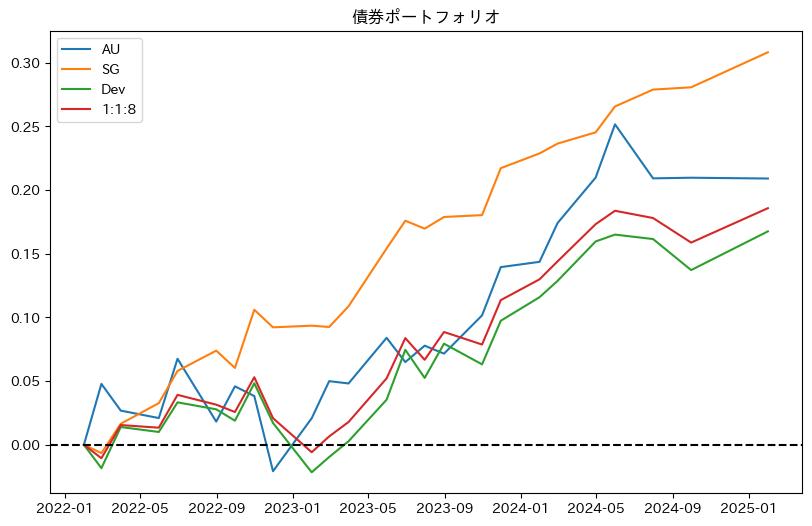

In [189]:
au = bond_df['au_bond_value'] - bond_df['au_bond_value'][0]
sg = bond_df['sg_bond_value'] - bond_df['sg_bond_value'][0]
dev = bond_df['dev_bond_value'] - bond_df['dev_bond_value'][0]

pf = 0.1 * au + 0.1 * sg + 0.8 * dev

fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(bond_df['date'], au, label='AU')
ax.plot(bond_df['date'], sg, label='SG')
ax.plot(bond_df['date'], dev, label='Dev')
ax.plot(bond_df['date'], pf, label='1:1:8')
ax.axhline(0, color='k', ls='--')
ax.legend()
ax.set_title('債券ポートフォリオ')

## 豪，シンガポール，先進国，現地通貨建て新興国

In [200]:
weights = np.array([0.1, 0.1, 0.55, 0.25]).T

# return
return_list = np.array([au_bond_cagr, sg_bond_cagr, dev_bond_cagr, em_bond_cagr])
return_p = weights @ return_list
print(f'portfolio return: {return_p:.2%}')

sg_bond_df = pl.DataFrame({
    'date': sg_bond['date'],
    'sg_bond_value': sg_bond['Value'].log()
})
dev_bond_df = pl.DataFrame({
    'date': dev_bond['date'],
    'dev_bond_value': dev_bond['nav'].log()
})
au_bond_df = pl.DataFrame({
    'date': au_bond['date'],
    'au_bond_value': au_bond['Value'].log()
})
em_bond_df = pl.DataFrame({
    'date': em_bond['date'],
    'em_bond_value': em_bond['nav'].log()
})
bond_df = sg_bond_df.join(
        dev_bond_df, on='date', how='left'
    ).join(
        au_bond_df, on='date', how='left'
    ).join(
        em_bond_df, on='date', how='left'
    ).drop_nulls()

tmp = np.array([
    bond_df['au_bond_value'].diff().drop_nulls(),
    bond_df['sg_bond_value'].diff().drop_nulls(),
    bond_df['dev_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_value'].diff().drop_nulls()
])
Sigma = np.cov(tmp)
sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'portfolio volatility: {sigma_p:.2%}')

rf = 0
sharpe_ratio = (return_p - rf) / sigma_p
print(f'sharp ratio: {sharpe_ratio:.2f}')

portfolio return: 7.04%
portfolio volatility: 6.55%
sharp ratio: 1.07


## 豪，シンガポール，現地通貨建て新興国，ドル建て新興国

In [226]:
weights = np.array([0.1, 0.1, 0.30, 0.25, 0.2]).T

# return
return_list = np.array([au_bond_cagr, sg_bond_cagr, dev_bond_cagr, em_bond_cagr, em_bond_doll_cagr])
return_p = weights @ return_list
print(f'portfolio return: {return_p:.2%}')

sg_bond_df = pl.DataFrame({
    'date': sg_bond['date'],
    'sg_bond_value': sg_bond['Value'].log()
})
dev_bond_df = pl.DataFrame({
    'date': dev_bond['date'],
    'dev_bond_value': dev_bond['nav'].log()
})
au_bond_df = pl.DataFrame({
    'date': au_bond['date'],
    'au_bond_value': au_bond['Value'].log()
})
em_bond_df = pl.DataFrame({
    'date': em_bond['date'],
    'em_bond_value': em_bond['nav'].log()
})
em_bond_doll_df = pl.DataFrame({
    'date': em_bond_doll['date'],
    'em_bond_doll_value': em_bond_doll['Value'].log()
})
bond_df = sg_bond_df.join(
        dev_bond_df, on='date', how='left'
    ).join(
        au_bond_df, on='date', how='left'
    ).join(
        em_bond_df, on='date', how='left'
    ).join(
        em_bond_doll_df, on='date', how='left'
    ).drop_nulls()

tmp = np.array([
    bond_df['au_bond_value'].diff().drop_nulls(),
    bond_df['sg_bond_value'].diff().drop_nulls(),
    bond_df['dev_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_doll_value'].diff().drop_nulls()
])
Sigma = np.cov(tmp)
sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'portfolio volatility: {sigma_p:.2%}')

rf = 0
sharpe_ratio = (return_p - rf) / sigma_p
print(f'sharp ratio: {sharpe_ratio:.2f}')

portfolio return: 7.80%
portfolio volatility: 6.14%
sharp ratio: 1.27


### リスクパリティ

In [241]:
sum_inv_vol = 1 / au_vol + 1 / sg_vol + 1 / dev_vol + 1 / lem_vol + 1 / dem_vol
weights = np.array([
    (1 / au_vol) / sum_inv_vol,
    (1 / sg_vol) / sum_inv_vol,
    (1 / dev_vol) / sum_inv_vol,
    (1 / lem_vol) / sum_inv_vol,
    (1 / dem_vol) / sum_inv_vol
])

print(weights)

weights = np.array([0.2, 0.2, 0.30, 0.15, 0.15]).T

# return
return_list = np.array([au_bond_cagr, sg_bond_cagr, dev_bond_cagr, em_bond_cagr, em_bond_doll_cagr])
return_p = weights @ return_list
print(f'portfolio return: {return_p:.2%}')

sg_bond_df = pl.DataFrame({
    'date': sg_bond['date'],
    'sg_bond_value': sg_bond['Value'].log()
})
dev_bond_df = pl.DataFrame({
    'date': dev_bond['date'],
    'dev_bond_value': dev_bond['nav'].log()
})
au_bond_df = pl.DataFrame({
    'date': au_bond['date'],
    'au_bond_value': au_bond['Value'].log()
})
em_bond_df = pl.DataFrame({
    'date': em_bond['date'],
    'em_bond_value': em_bond['nav'].log()
})
em_bond_doll_df = pl.DataFrame({
    'date': em_bond_doll['date'],
    'em_bond_doll_value': em_bond_doll['Value'].log()
})
bond_df = sg_bond_df.join(
        dev_bond_df, on='date', how='left'
    ).join(
        au_bond_df, on='date', how='left'
    ).join(
        em_bond_df, on='date', how='left'
    ).join(
        em_bond_doll_df, on='date', how='left'
    ).drop_nulls()

tmp = np.array([
    bond_df['au_bond_value'].diff().drop_nulls(),
    bond_df['sg_bond_value'].diff().drop_nulls(),
    bond_df['dev_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_doll_value'].diff().drop_nulls()
])
Sigma = np.cov(tmp)
sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'portfolio volatility: {sigma_p:.2%}')

rf = 0
sharpe_ratio = (return_p - rf) / sigma_p
print(f'sharp ratio: {sharpe_ratio:.2f}')

[0.18010446 0.1921673  0.30354135 0.16294651 0.16124038]
portfolio return: 7.48%
portfolio volatility: 5.78%
sharp ratio: 1.29


In [269]:
america = 47.38 * weights[2] + 27.4 * weights[3] + 44.74 * weights[4]
asia_pacific = 100 * weights[0] + 100 * weights[1] + 13.77 * weights[2] + 39.5 * weights[3] + 5.87 * weights[4]
emea = 37.75 * weights[2] + 30.7 * weights[3] + 46.69 * weights[4]

# np.sqrt(((america - 100 / 3) ** 2 + (asia_pacific - 100 / 3) ** 2 + (emea - 100 / 3) ** 2) / 3)
np.std([america, asia_pacific, emea])

12.73434556840498

## 均等ポートフォリオ

In [275]:
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2]).T

# return
return_list = np.array([au_bond_cagr, sg_bond_cagr, dev_bond_cagr, em_bond_cagr, em_bond_doll_cagr])
return_p = weights @ return_list
print(f'portfolio return: {return_p:.2%}')

sg_bond_df = pl.DataFrame({
    'date': sg_bond['date'],
    'sg_bond_value': sg_bond['Value'].log()
})
dev_bond_df = pl.DataFrame({
    'date': dev_bond['date'],
    'dev_bond_value': dev_bond['nav'].log()
})
au_bond_df = pl.DataFrame({
    'date': au_bond['date'],
    'au_bond_value': au_bond['Value'].log()
})
em_bond_df = pl.DataFrame({
    'date': em_bond['date'],
    'em_bond_value': em_bond['nav'].log()
})
em_bond_doll_df = pl.DataFrame({
    'date': em_bond_doll['date'],
    'em_bond_doll_value': em_bond_doll['Value'].log()
})
bond_df = sg_bond_df.join(
        dev_bond_df, on='date', how='left'
    ).join(
        au_bond_df, on='date', how='left'
    ).join(
        em_bond_df, on='date', how='left'
    ).join(
        em_bond_doll_df, on='date', how='left'
    ).drop_nulls()

tmp = np.array([
    bond_df['au_bond_value'].diff().drop_nulls(),
    bond_df['sg_bond_value'].diff().drop_nulls(),
    bond_df['dev_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_value'].diff().drop_nulls(),
    bond_df['em_bond_doll_value'].diff().drop_nulls()
])
Sigma = np.cov(tmp)
sigma_p = np.sqrt(weights.T @ Sigma @ weights) * np.sqrt(12)
print(f'portfolio volatility: {sigma_p:.2%}')

rf = 0
sharpe_ratio = (return_p - rf) / sigma_p
print(f'sharp ratio: {sharpe_ratio:.2f}')

portfolio return: 7.80%
portfolio volatility: 5.86%
sharp ratio: 1.33


In [ ]:
america = 47.38 * weights[2] + 27.4 * weights[3] + 44.74 * weights[4]
asia_pacific = 100 * weights[0] + 100 * weights[1] + 13.77 * weights[2] + 39.5 * weights[3] + 5.87 * weights[4]
emea = 37.75 * weights[2] + 30.7 * weights[3] + 46.69 * weights[4]

print(f'america: {america:.2f}')
print(f'asia_pacific: {asia_pacific:.2f}')
print(f'emea: {emea:.2f}')

# 偏差２乗和
# (america - 100 / 3) ** 2 + (asia_pacific - 100 / 3) ** 2 + (emea - 100 / 3) ** 2
np.std([america, asia_pacific, emea])

america: 23.90
asia_pacific: 51.83
emea: 23.03


13.374757119290052

Text(0.5, 1.0, '債券ポートフォリオ')

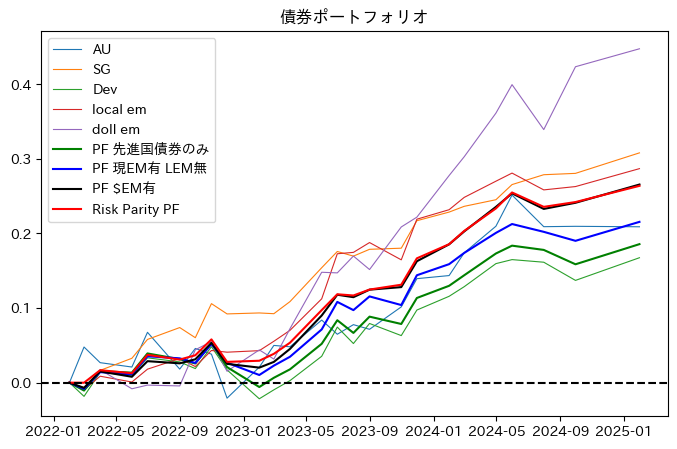

In [271]:
au = bond_df['au_bond_value'] - bond_df['au_bond_value'][0]
sg = bond_df['sg_bond_value'] - bond_df['sg_bond_value'][0]
dev = bond_df['dev_bond_value'] - bond_df['dev_bond_value'][0]
lem = bond_df['em_bond_value'] - bond_df['em_bond_value'][0]
dem = bond_df['em_bond_doll_value'] - bond_df['em_bond_doll_value'][0]

dev_only_pf = 0.1 * au + 0.1 * sg + 0.8 * dev
lem_pf = 0.1 * au + 0.1 * sg + 0.55 * dev + 0.25 * lem
dem_pf = 0.1 * au + 0.1 * sg + 0.4 * dev + 0.2 * lem + 0.2 * dem
rp_pf = 0.2 * au + 0.2 * sg + 0.3 * dev + 0.15 * lem + 0.15 * dem

fig, ax = plt.subplots(figsize=(1.618*5, 5))
ax.plot(bond_df['date'], au, label='AU', lw=0.8)
ax.plot(bond_df['date'], sg, label='SG', lw=0.8)
ax.plot(bond_df['date'], dev, label='Dev', lw=0.8)
ax.plot(bond_df['date'], lem, label='local em', lw=0.8)
ax.plot(bond_df['date'], dem, label='doll em', lw=0.8)
ax.plot(bond_df['date'], dev_only_pf, label='PF 先進国債券のみ', lw=1.5, color='green')
ax.plot(bond_df['date'], lem_pf, label='PF 現EM有 LEM無', lw=1.5, color='blue')
ax.plot(bond_df['date'], dem_pf, label='PF $EM有', lw=1.5, color='black')
ax.plot(bond_df['date'], rp_pf, label='Risk Parity PF', lw=1.5, color='red')
ax.axhline(0, color='k', ls='--')
ax.legend()
ax.set_title('債券ポートフォリオ')

Text(0.5, 1.0, '債券ポートフォリオ')

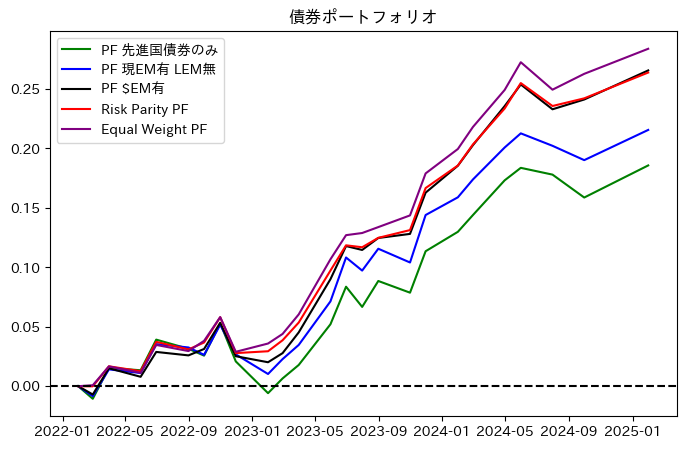

In [273]:
au = bond_df['au_bond_value'] - bond_df['au_bond_value'][0]
sg = bond_df['sg_bond_value'] - bond_df['sg_bond_value'][0]
dev = bond_df['dev_bond_value'] - bond_df['dev_bond_value'][0]
lem = bond_df['em_bond_value'] - bond_df['em_bond_value'][0]
dem = bond_df['em_bond_doll_value'] - bond_df['em_bond_doll_value'][0]

dev_only_pf = 0.1 * au + 0.1 * sg + 0.8 * dev
lem_pf = 0.1 * au + 0.1 * sg + 0.55 * dev + 0.25 * lem
dem_pf = 0.1 * au + 0.1 * sg + 0.4 * dev + 0.2 * lem + 0.2 * dem
rp_pf = 0.2 * au + 0.2 * sg + 0.3 * dev + 0.15 * lem + 0.15 * dem
eq_pf = 0.2 * au + 0.2 * sg + 0.2 * dev + 0.2 * lem + 0.2 * dem

fig, ax = plt.subplots(figsize=(1.618*5, 5))
# ax.plot(bond_df['date'], au, label='AU', lw=0.8)
# ax.plot(bond_df['date'], sg, label='SG', lw=0.8)
# ax.plot(bond_df['date'], dev, label='Dev', lw=0.8)
# ax.plot(bond_df['date'], lem, label='local em', lw=0.8)
# ax.plot(bond_df['date'], dem, label='doll em', lw=0.8)
ax.plot(bond_df['date'], dev_only_pf, label='PF 先進国債券のみ', lw=1.5, color='green')
ax.plot(bond_df['date'], lem_pf, label='PF 現EM有 LEM無', lw=1.5, color='blue')
ax.plot(bond_df['date'], dem_pf, label='PF $EM有', lw=1.5, color='black')
ax.plot(bond_df['date'], rp_pf, label='Risk Parity PF', lw=1.5, color='red')
ax.plot(bond_df['date'], eq_pf, label='Equal Weight PF', lw=1.5, color='purple')
ax.axhline(0, color='k', ls='--')
ax.legend()
ax.set_title('債券ポートフォリオ')